# Block coalescent

In [111]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

R header:

In [112]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
#devtools::install_local('../../PtDAlgorithms', quiet=FALSE)
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


In [113]:
# remove.packages("ptdalgorithms")

In [114]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [115]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [116]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [117]:
# Rcpp::sourceCpp("./timeinhom-kingman.cpp")

In [118]:
source("plot_functions.R")

In [119]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

In [120]:
plot_sfs <- function(graph, rewards) {
    sfs <- apply(rewards, 1, function(x) expectation(graph, x))
    data.frame(
      ton=seq(1,length(sfs)),  
      brlen=sfs
      ) %>% ggplot(aes(x=ton, y=brlen, fill=ton)) + 
      geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + 
          scale_x_continuous(breaks = 1:(dim(rewards)[1])) +
          theme(legend.position = "none") + labs(x='nr descendants') +
          labs(y = "Total branch length", x = "Number of descendants") +
          despine
}
                 
get_cov_mat <- function(graph, rewards) {
    n <- nrow(rewards)
    cov_mat <- matrix(nrow=n,ncol=n)
    for (i in 1:(n)) {
        for (j in 1:(n)) {
            cov_mat[i, j] <- covariance(graph, rewards[i,], rewards[j,])
        }
    }
    return(cov_mat)
}
                  
plot_cov_mat <- function(cov_mat) {
   
    df <- as.data.frame(cov_mat)
    df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
    df$ton1 <- as.character(df$ton1)
    df$ton2 <- gsub("V","",as.character(df$ton2))
    df$ton1 <- factor(df$ton1, levels=unique(df$ton1[order(as.numeric(df$ton1))]))
    df$ton2 <- factor(df$ton2, levels=unique(df$ton2[order(as.numeric(df$ton2))]))
    
    ggplot(df, aes(ton1, ton2)) +
        geom_tile(aes(fill = value)) + 
        scale_y_discrete(labels= seq(1, nrow(cov_mat))) + 
        scale_fill_continuous(type = "viridis") + 
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(), text=element_text(size=17)) 

}

# Block coalescent

In [329]:
block_coalescent <- function(n) {
      
    state_vector_length <- 1
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(0)
    initial_state[1] <- n
    add_edge(starting_vertex, create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] == 1) {
        break
      }
      rate <- state[1] * (state[1] - 1) / 2
      child_state <- state
      child_state[1] <- child_state[1] - 1
      add_edge(vertex, find_or_create_vertex(graph, child_state), rate)
      index <- index + 1
    }
    return(graph)
}

In [330]:
n <- 5
graph <- block_coalescent(n)
gam <- graph_as_matrix(graph)

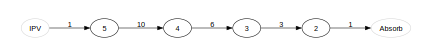

In [331]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

In [332]:
library("partitions")

# equivalence_classes <- function(n) {
#     p <- parts(n)
#     return(apply(p, 2, function(x) {x[x!=0]}))
# }

equivalence_classes <- function(n, size=0) {
    if (size != 0) {    
        m <- apply(parts(n), 2, function(x) {x[x!=0]})
        p <- m[lapply(m, length) == size]
    } else {
        p <- apply(parts(n), 2, function(x) {x[x!=0]})
    }
    return(p)
}

ton_counts <- function(p, n) {
    result <- rep(0, n)
    counts <- table(p)
    for (i in seq(n)) {
        c <- counts[names(counts)==i]
        if (length(c)) {
            result[i] <- c
        }
    }
    return(result)
}
multinom <- function(params) {
    if (length(params) == 1) {
        return(1)
    }
    return(choose(sum(params), params[length(params)]) * multinom(params[-length(params)]))
}

In [333]:
coalescent_reward_matrix <- function(n) {
    rewards <- matrix(0, n, n)
    for (p in equivalence_classes(n)) {
        counts <- ton_counts(p, n)
        rewards[length(p), ] <- rewards[length(p), ] + counts * multinom(counts)
    }
    rewards <- rewards[-1, -ncol(rewards)]
    if (n == 2) {
        stopifnot(0, "NOT IMPLEMENTED")
        scale <- 2/sum(rewards)
        rewards <- rewards * scale
        rewards <- c(0, rewards, 0)
    } else {
        scale <- (2:n)/apply(rewards, 1, sum)
        rewards <- rewards * scale
        rewards <- t(rewards)[, ncol(rewards):1]
        rewards <- cbind(rep(0, nrow(rewards)), rewards, rep(0, nrow(rewards)))
    }
    return(rewards)        
}
rewards <- coalescent_reward_matrix(5)
print(rewards)
expectation(graph, rewards[3, ])

     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    5    3  1.5  0.5    0
[2,]    0    0    1  1.0  0.5    0
[3,]    0    0    0  0.5  0.5    0
[4,]    0    0    0  0.0  0.5    0


[1] 0.6666667

In [334]:
get_block_rewards <- function(n, l) {
    # a column in the matrix computed by get_block_rewards
    rewards <- matrix(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        rewards = rewards + counts * multinom(counts)
    }

    rewards <- rewards[-length(rewards)]
    if (sum(rewards) > 0) {
        scale <- l/sum(rewards)
        rewards <- rewards * scale
    }
    rewards <- c(0, rewards)
    return(matrix(rewards))
}
get_block_rewards(5, 3)

0.0
1.5
1.0
0.5
0.0


In [335]:
# rewards <- sapply((n-1):2, function(x) get_block_rewards(n, x))
# rewards <- cbind(rep((n-1)), rewards)
# rewards

In [336]:
tensor_dims <- c(n, vertices_length(graph))
reward_fun <- get_block_rewards

reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
rewards

0,0,0,0.0,0.0,0
0,5,3,1.5,0.5,0
0,0,1,1.0,0.5,0
0,0,0,0.5,0.5,0
0,0,0,0.0,0.5,0


In [338]:
expectation(graph, rewards[4, ])

[1] 0.6666667

Precompute rewards for a range of sample sizes:

In [128]:
# if (!require("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")

# # The following initializes usage of Bioc devel
# BiocManager::install(version='devel')

# BiocManager::install("rhdf5")

In [129]:
# library(rhdf5)
# # h5createFile("myhdf5file.h5")
# h5f = H5Fopen("myhdf5file.h5")

# h5closeAll()

In [130]:
# for (n in 80:100) {
#     start <- proc.time()[3]
#     rewards <- get_block_rewards(n)
#     end <- proc.time()[3]
#     print(c(n, (end - start)[['elapsed']]))
#     flush.console()
# }

In [339]:
library(parallel)

redo_sfs_rewards <- TRUE

if (redo_sfs_rewards) {
    v <- 3:20
    n_list <- as.list(v)
    names(n_list) <- v
    sfs_rewards <- mclapply(n_list, coalescent_reward_matrix, mc.cores=detectCores())
    saveRDS(sfs_rewards, file="sfs_rewards.RData")
} else {
    sfs_rewards <- readRDS(file="sfs_rewards.RData")
}

In [340]:
sfs_rewards[[as.character(4)]]

0,4,2,0.6666667,0
0,0,1,0.6666667,0
0,0,0,0.6666667,0


In [341]:
rewards <- sfs_rewards[[as.character(n)]]
sfs_expectation <- apply(rewards, 1, function(x) expectation(graph, x))
sfs_expectation

[1] 2.0000000 1.0000000 0.6666667 0.5000000

In [342]:
sfs_variance <- apply(rewards, 1, function(x) variance(graph, x))
sfs_variance

[1] 1.0000000 0.3888889 0.2777778 0.2500000

Compute the first `m` moments for each "ton" for `n` samples:

In [343]:
n <- 8
m <- 10
graph <- block_coalescent(n)
rewards <- sfs_rewards[[as.character(n)]]
sfs_moments <- data.frame(apply(rewards, 1, function(x) moments(graph, m, x)))
row.names(sfs_moments) <- 1:m
names(sfs_moments) <- 1:(n-1)
sfs_moments

,1,2,3,4,5,6,7
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.000000e+00,1.000000,0.6666667,0.5000000,0.4000000,0.3333333,0.2857143
2,4.571429e+00,1.206349,0.5790476,0.3555102,0.2510658,0.1950113,0.1632653
3,1.175510e+01,1.714286,0.6293437,0.3361224,0.2216676,0.1678005,0.1399417
4,3.358601e+01,2.816974,0.8300391,0.4024233,0.2558018,0.1918954,0.1599334
5,1.055560e+02,5.273729,1.2967891,0.5880475,0.3666063,0.2741656,0.2284762
6,3.619063e+02,11.111957,2.3537585,1.0193923,0.6291395,0.4700066,0.3916735
7,1.344224e+03,26.083899,4.8848375,2.0501088,1.2587268,0.9400159,0.7833471
8,5.376894e+03,67.624569,11.4383549,4.6989110,2.8774309,2.1486089,1.7905076
9,2.304383e+04,192.200692,29.8838264,12.0995646,7.3994005,5.5249948,4.6041624


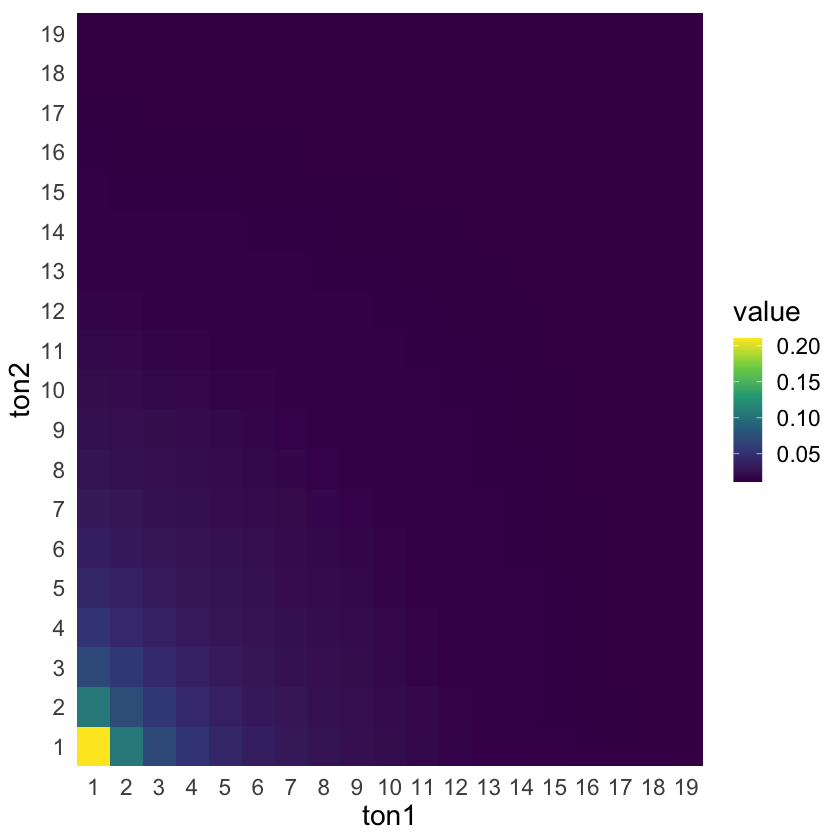

In [344]:
n <- 20
graph <- block_coalescent(n)
rewards <- sfs_rewards[[as.character(n)]]
plot_cov_mat(get_cov_mat(graph, rewards))

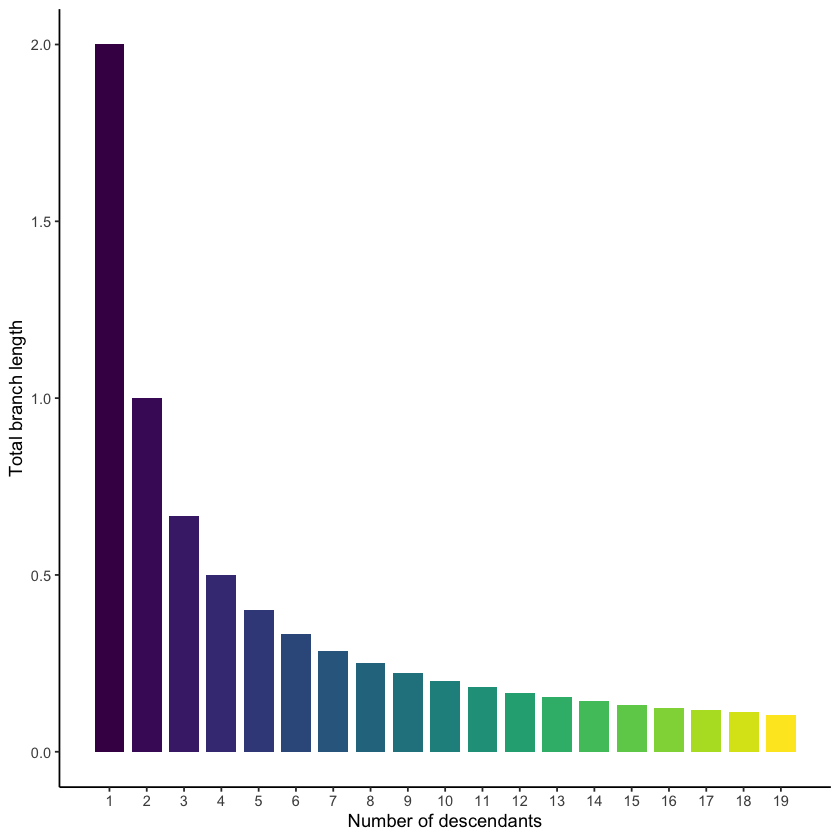

In [345]:

plot_sfs(graph, rewards) 
ggsave('~/Desktop/sfs.pdf', width=6, height=4) 

In [346]:
block_arg <- function(n) {
      
    state_vector_length <- 3
    graph <- create_graph(state_vector_length)
    starting_vertex <- vertex_at(graph, 1)
    initial_state <- c(n, n, n)
    add_edge(starting_vertex, find_or_create_vertex(graph, initial_state), 1)
    index <- 2
    
    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)
      state <- vertex$state
      if (state[1] <= 1 && state[2] <= 1 ) {
        index <- index + 1 
        next
      }

      l1 <- state[1] - state[3]
      l2 <- state[2] - state[3]
      l1l2 <- state[3]

      if (l1 >= 1) {
        if (l1 >= 2 || l1l2 >= 1) {
            rate <- (l1 * (l1 - 1) / 2) + l1*l1l2
            child_state <- state
            child_state[1] <- child_state[1] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }
      if (l2 >= 1) {
        if (l2 >= 2 || l1l2 >= 1) {
            rate <- (l2 * (l2 - 1) / 2) + l1*l1l2
            child_state <- state
            child_state[2] <- child_state[2] - 1
            add_edge(vertex, find_or_create_vertex(graph, child_state), rate) 
            
        }          
      }         
      # if (l1 >= 1 && l2 >= 1) {
      #   rate <- l1 * l2
      #   child_state <- state
      #   child_state[3] <- child_state[3] + 1

      #   # Even though this links the two loci, we don't count it because the
      #   # "re-linking" is random and does not reflect original linking 
          
      #   add_edge(vertex, find_or_create_vertex(graph, child_state), rate)   
      # }
      if (l1l2 >=2) {
        rate <- l1l2 * (l1l2 - 1) / 2
        child_state <- state
        child_state[1] <- child_state[1] - 1
        child_state[2] <- child_state[2] - 1
        child_state[3] <- child_state[3] - 1          
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }        

      # recombination
      if (l1l2 >=1) {        
        rate <- 2             # hardcoded recombination rate
        child_state <- state
        child_state[3] <- child_state[3] - 1          
        add_edge(vertex, find_or_create_vertex(graph, child_state), rate)  
      }

      index <- index + 1 
    }
    return(graph)
}

n <- 8
graph <- block_arg(n)
vertices_length(graph)

[1] 269

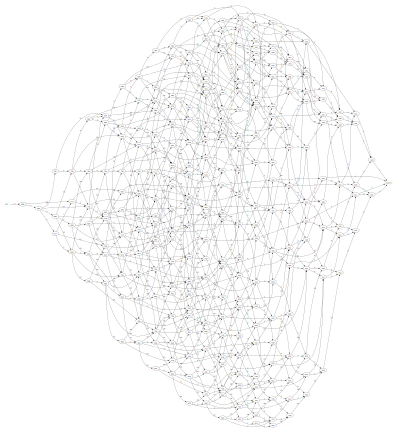

In [347]:
plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25)

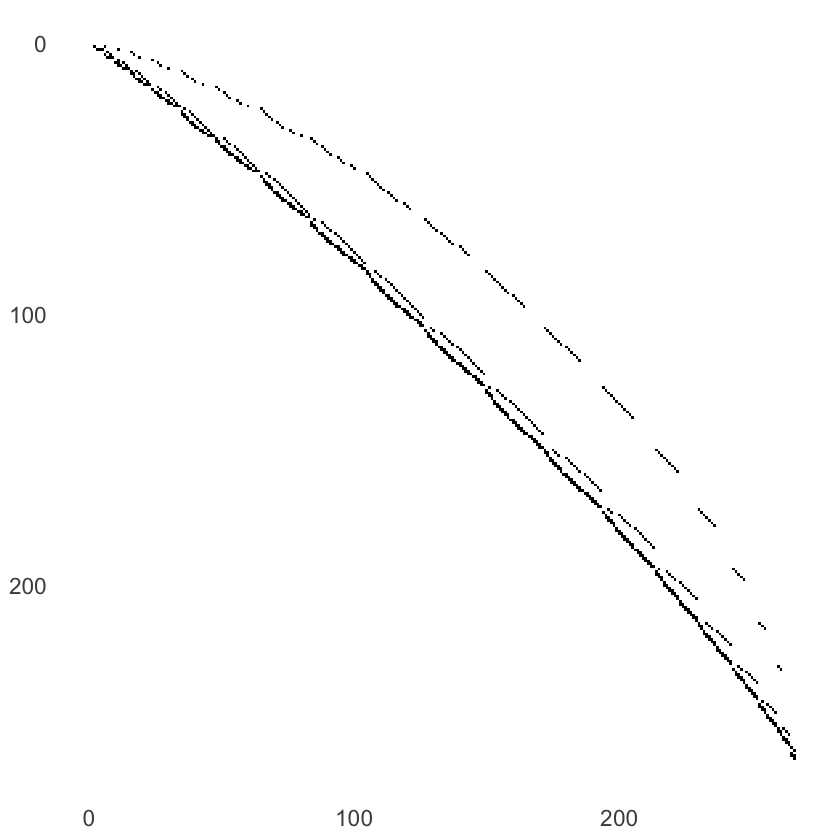

In [348]:
plot_sim <- function(graph)
{
    gam <- graph_as_matrix(graph)
    mat <- t(gam$SIM)
    mat <- matrix(as.integer(mat > 0), dim(mat))
    
    rownames(mat) <- 1:nrow(mat)
    colnames(mat) <- 1:ncol(mat)
    df <- as.data.frame(mat)
    df <- df %>% rownames_to_column('n') %>% gather('m', 'value', -c(n))
    df$n <- as.numeric(df$n)
    df$m <- as.numeric(df$m)
    ggplot(df, aes(n, m)) +
        geom_tile(aes(fill = value), show.legend = FALSE) + 
        scale_y_reverse() +
        scale_fill_gradient(low="white", high="black") +
        theme_minimal() + 
        theme(panel.grid.major = element_blank(), 
              panel.grid.minor = element_blank(), 
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              text=element_text(size=17))
}

plot_sim(graph)

In [349]:

marg_tree_rewards <- function(n, l) {
    r <- rep(0, n)
    for (p in equivalence_classes(n, size=l)) {
        counts <- ton_counts(p, n)
        r <- r + counts * multinom(counts)
    }
    scale <- l / sum(r)
    r <- r * scale
    return(r)
}
            
arg_state_reward <- function(n, locus1, locus2, linked) {

    l1 <- locus1 - linked
    l2 <- locus2 - linked

    rewards <- matrix(0, n+1, n+1)
    if (locus1 + locus2 == 0) {
        return(rewards)
    }
    part <- equivalence_classes(n, size=linked)
    for (l1_p in part) {
        for (l2_p in part) {
            for (a in l1_p) {
                for (b in l2_p) {
                    rewards[a+1, b+1] <- rewards[a+1, b+1] +
                        (1 - (linked / locus1)) * multinom(ton_counts(l1_p, n)) + 
                        (1 - (linked / locus2)) * multinom(ton_counts(l2_p, n)) 
                }
            }
        }
    }
    for (i in 1:length(part)) {
        p <- part[i][[1]]
        for (a in p) {
            rewards[a+1, a+1] <- rewards[a+1, a+1] + 
                (linked / locus1) * multinom(ton_counts(p, n)) + 
                (linked / locus2) * multinom(ton_counts(p, n)) 
        }
    }

    # for (i in 2:(n+1) > 0) {
    #     for (p in equivalence_classes(n, size=l1)) {
    #         counts <- ton_counts(p, n)
    #         rewards[i, ] <- rewards[i, ] + (1 - (linked / locus1)) * c(0, (counts * multinom(counts)))
    #     }
    #     for (p in equivalence_classes(n, size=l2)) {
    #         counts <- ton_counts(p, n)
    #         rewards[, i] <- rewards[, i] + (1 - (linked / locus2)) * c(0, (counts * multinom(counts)))
    #     }
    # }
    
    rewards[n+1, n+1] = 0
    
    if (sum(rewards) > 0) {
        scale <- linked / sum(rewards)
        rewards <- rewards * scale
    }
    
    if (l1 > 0) {
        rewards[1, ] <- c(0, marg_tree_rewards(n, l1) )
    }
    if (l2 > 0) {
        rewards[, 1] <- c(0, marg_tree_rewards(n, l2) )
    }
    return(rewards)
}
arg_state_reward(5, 1, 5, 1)

0,0,0,0,0,0
3,0,0,0,0,0
1,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0
0,0,0,0,0,0


In [350]:
tensor_dims <- c((n+1), (n+1), vertices_length(graph))
reward_fun <- arg_state_reward
reward_list <- lapply(1:vertices_length(graph), function(i) do.call(reward_fun, as.list(c(n, vertex_at(graph, i)$state))))
rewards <- array(unlist(reward_list), dim=tensor_dims)
print(dim(rewards))
expectation(graph, rewards[4, 4, ])

[1]   9   9 269


[1] 0.2692824

In [351]:
exp_mat <- matrix(0, nrow=n+1,ncol=n+1)
for (i in 1:(n+1)) {
  for (j in 1:(n+1)) {
    exp_mat[i,j] <- expectation(graph, rewards[i, j, ])
  }
} 
exp_mat

0.0000000,0.216568108,0.209889565,0.203411415,0.197127983,0.191033747,0.185123338,0.179391533,0.9081407
0.2975431,1.371337254,0.049308809,0.028253724,0.019601837,0.011400114,0.008009954,0.004995038,0.0000000
0.2844009,0.050270822,0.516276591,0.023083004,0.017605608,0.010689699,0.007759234,0.004995038,0.0000000
0.2717898,0.028258104,0.022561998,0.269282417,0.013981459,0.008995620,0.007130865,0.004995038,0.0000000
0.2596911,0.020529095,0.018156411,0.014844841,0.169812486,0.010588714,0.009517559,0.008010101,0.0000000
0.2480870,0.011343476,0.010393432,0.008826283,0.009483044,0.110838779,0.005874127,0.004995038,0.0000000
0.2369601,0.008263814,0.007886164,0.007257795,0.008609401,0.006001057,0.080047090,0.004995038,0.0000000
0.2262936,0.004995038,0.004995038,0.004995038,0.006975012,0.004995038,0.004995038,0.060272831,0.0000000
0.8340862,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000


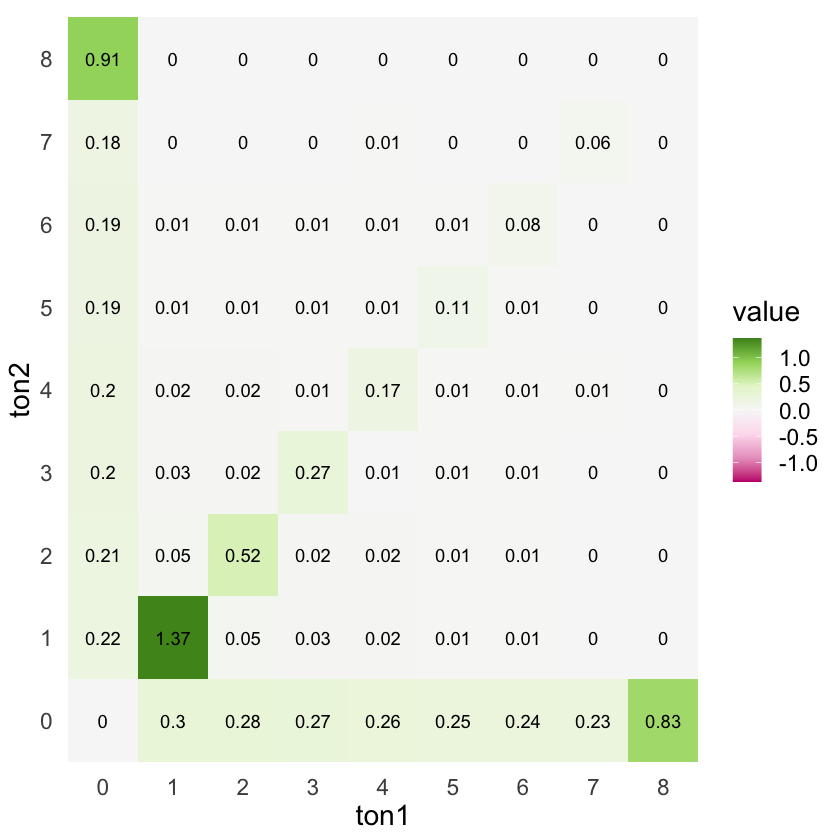

In [352]:
df <- as.data.frame(exp_mat) #%>% gather()
df <- df %>% rownames_to_column('ton1') %>% gather('ton2', 'value', -c(ton1))
limit <- max(na.omit(abs(df$value))) * c(-1, 1)
ggplot(df, aes(ton1, ton2)) +
    geom_tile(aes(fill = value)) + 
    geom_text(aes(label = round(value, 2))) +
    scale_x_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_y_discrete(labels= seq(0, nrow(exp_mat))) + 
    scale_fill_distiller(palette = 'PiYG',direction = 1, limit=limit) +
    theme_minimal() +
    theme(panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        text=element_text(size=17))

In [392]:
exp_mat[, 1] / sum(exp_mat[, 1])

[1] 0.0000000 0.1900903 0.1761859 0.1632505 0.1512236 0.3192498

In [390]:
exp_mat[1, ] / exp_mat[, 1]

[1]       NaN 0.7773063 0.7922524 0.8078087 0.8239890 1.0819017